In [1]:
# Libraries

import argparse
import numpy
import os
import json
import torch
import platform
import shutil
import sys

In [2]:
# Ensure source path

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux'   : ROOT = '/d/hpc/projects/FRI/up4472/upolanc-thesis'
		elif platform.system() == 'Windows' : ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else : raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		print()

		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Code

from source.python.cnn.models import Zrimec2020r
from source.python.cnn.models import Zrimec2020c

from source.python.cnn      import cnn_motifs
from source.python.encoding import onehot
from source.python.io       import loader
from source.python          import runtime

runtime.set_numpy_format()
runtime.set_pandas_format()
runtime.set_plot_theme()

In [4]:
# Setup some directory paths.

FILTER    = 2
SUBFOLDER = 'filter' + str(FILTER)

CWD       = ROOT
OUT       = os.path.join(CWD, 'output')
OUT_DATA  = os.path.join(OUT, 'nbp15-motifs')
RES_NBP04 = os.path.join(OUT, 'nbp04-feature', SUBFOLDER)

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f' Resource Directory : {RES_NBP04}')
print()

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp15-motifs
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp04-feature\filter2



In [5]:
# Constants

range_sequence       = [50, 100]

nucleotide_order     = 'ACGT'
nucleotide_value     = 'fraction'

display_motifs       = 'probability'
display_cols         = 8
display_rows         = 4
display_size         = [(16, 10), (16, 16)]

activation_weighted  = True
activation_threshold = [0, numpy.PINF]

print('Sequence Bot Index       : {}'.format(range_sequence[0] if range_sequence is not None else None))
print('Sequence Top Index       : {}'.format(range_sequence[1] if range_sequence is not None else None))
print('Nucleotide Order         : {}'.format(nucleotide_order))
print('Nucleotide Value         : {}'.format(nucleotide_value))
print('Motif Display            : {}'.format(display_motifs))
print('Activation Weighted      : {}'.format(activation_weighted))
print('Activation Bot Threshold : {}'.format(activation_threshold[0]))
print('Activation Top Threshold : {}'.format(activation_threshold[1]))
print()

Sequence Bot Index       : 50
Sequence Top Index       : 100
Nucleotide Order         : ACGT
Nucleotide Value         : fraction
Motif Display            : probability
Activation Weighted      : True
Activation Bot Threshold : 0
Activation Top Threshold : inf



In [6]:
# System and device

DEVICE = runtime.get_device(only_cpu = False)
SYSTEM = runtime.get_system_info()

for key, value in SYSTEM.items() :
	print('{:25s} : {}'.format(key, value))

print()

platform/python           : 3.10.7
platform/system           : Windows
platform/release          : 10
platform/version          : 10.0.19044
platform/cpu/name         : N/A
platform/cpu/count        : 12
platform/gpu/name         : NVIDIA GeForce RTX 3060 Ti
platform/gpu/available    : True
platform/gpu/count        : 1
platform/memory/total     : 31.924 GB
platform/memory/available : 10.983 GB



In [7]:
# Define sequence paths

sequence_keep = os.path.join(RES_NBP04, 'sequences-2150-keep.fasta')
sequence_drop = os.path.join(RES_NBP04, 'sequences-2150-drop.fasta')
mutation_keep = os.path.join(RES_NBP04, 'mutation-sequences-2150.fasta')

In [8]:
#

sequence_keep = loader.load_fasta(
	filename  = sequence_keep,
	to_string = True
)

sequence_drop = loader.load_fasta(
	filename  = sequence_drop,
	to_string = True
)

mutation_sequence = loader.load_fasta(
	filename  = mutation_keep,
	to_string = True
)

if range_sequence is not None : sequence = list(sequence_keep.values())[range_sequence[0]:range_sequence[1]]
else                          : sequence = list(sequence_keep.values())

In [9]:
# Load model

folder_path = os.path.join(OUT, 'nbp07-switch', 'zrimec-f2-c')
models_path = os.path.join(folder_path, 'model', 'zrimec2020c-best.pth')
config_path = os.path.join(folder_path, 'config.json')

print(' Model Path : {}'.format(models_path))
print('Config Path : {}'.format(config_path))
print()

with open(config_path, mode = 'r') as handle :
	CONFIG = json.load(handle)

model = Zrimec2020c(
	params = CONFIG,
	binary = True
)

print(model.summary(
	batch_size  = CONFIG['dataset/batch/train'],
	in_height   = CONFIG['model/input/height'],
	in_width    = CONFIG['model/input/width'],
	in_features = CONFIG['model/input/features'],
))

print()

 Model Path : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp07-switch\zrimec-f2-c\model\zrimec2020c-best.pth
Config Path : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp07-switch\zrimec-f2-c\config.json

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
Zrimec2020c                              [32, 4, 2150]             [32, 1]                   --
├─Zrimec2020: 1-1                        [32, 4, 2150]             [32, 128]                 --
│    └─Conv1d: 2-1                       [32, 4, 2150]             [32, 256, 2150]           5,376
│    └─LeakyReLU: 2-2                    [32, 256, 2150]           [32, 256, 2150]           --
│    └─BatchNorm1d: 2-3                  [32, 256, 2150]           [32, 256, 2150]           512
│    └─Dropout: 2-4                      [32, 256, 2150]           [32, 256, 2150]           --
│    └─MaxPool1d: 2-5                    [32, 256, 2150]           [32, 256, 

In [10]:
# Load state dict and convert to double

model.load_state_dict(
	torch.load(models_path)['models']
)

model = model.double()

In [11]:
# Get convolutional layers and generate one hot encoding mapping

data = cnn_motifs.get_conv_layers_from_model(
	model = model
)

mapping = onehot.generate_onehot_mapping(
	nucleotide_order = nucleotide_order,
	ambiguous_value  = nucleotide_value
)

In [12]:
# Compute kernel activations (pretty slow ~ can be up to 12h)
# 256 filters, 5x4 kernels,    50 sequences ~   2 min
# 256 filters, 5x4 kernels, 20000 sequences ~ 800 min

activations = cnn_motifs.get_kernel_activations(
	sequences = sequence,
	mapping   = mapping,
	layer     = data['layer'][0],
	device    = DEVICE,
	weighted  = activation_weighted,
	threshold = activation_threshold
)

activations = {i : x for i, x in enumerate(activations)}

Filters : 256
Width   : 5
Height  : 4



Minimum Value : 0.23908
Maximum Value : 0.26877



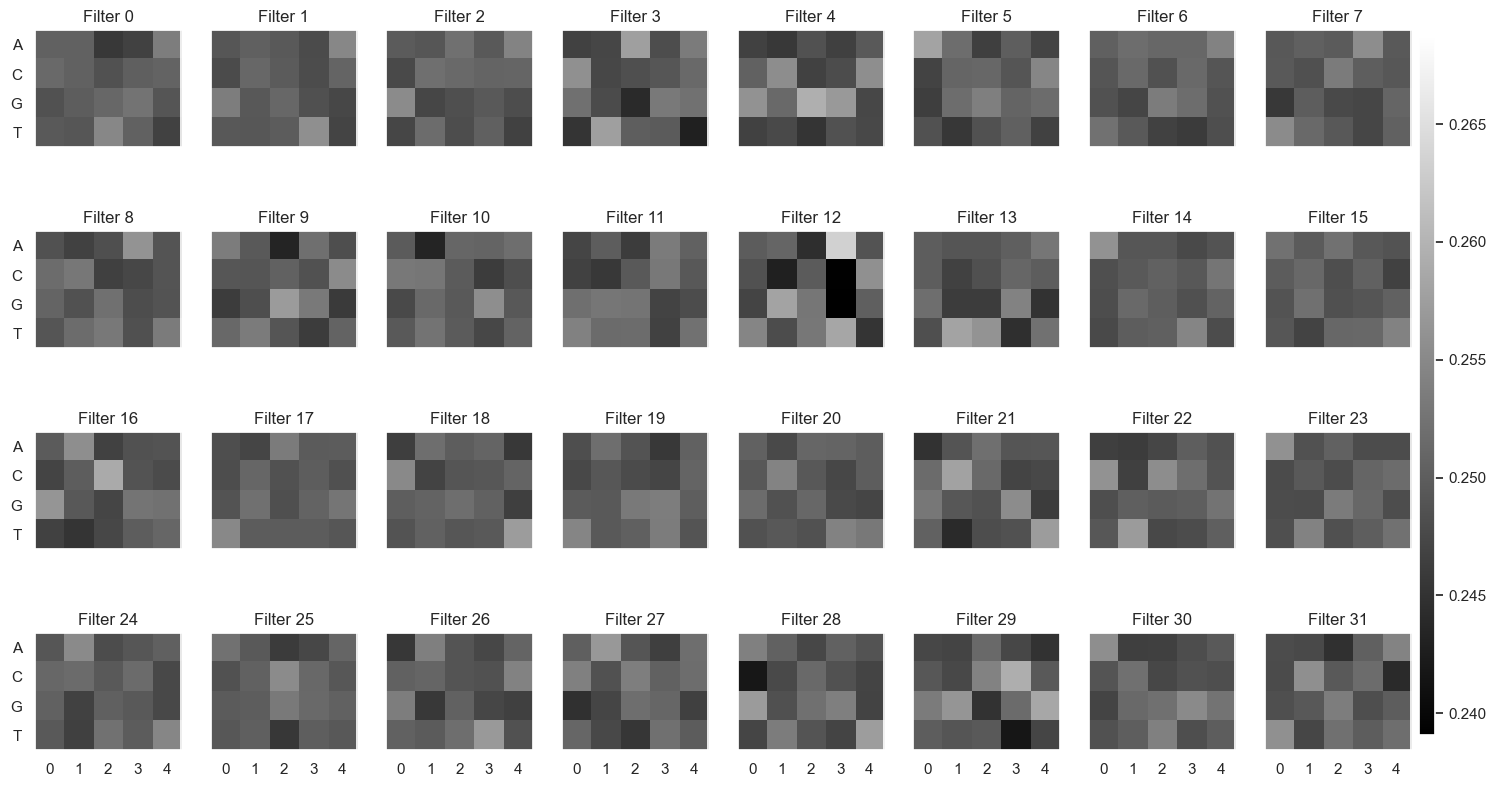

In [13]:
# Plot kernels

cnn_motifs.plot_kernels(
	weights          = data['weight'][0],
	nucleotide_order = nucleotide_order,
	filename         = os.path.join(OUT_DATA, 'activation-kernel'),
	cols             = display_cols,
	rows             = display_rows,
	figsize          = display_size[0]
)

Minimum Value : 0.23908
Maximum Value : 0.26877



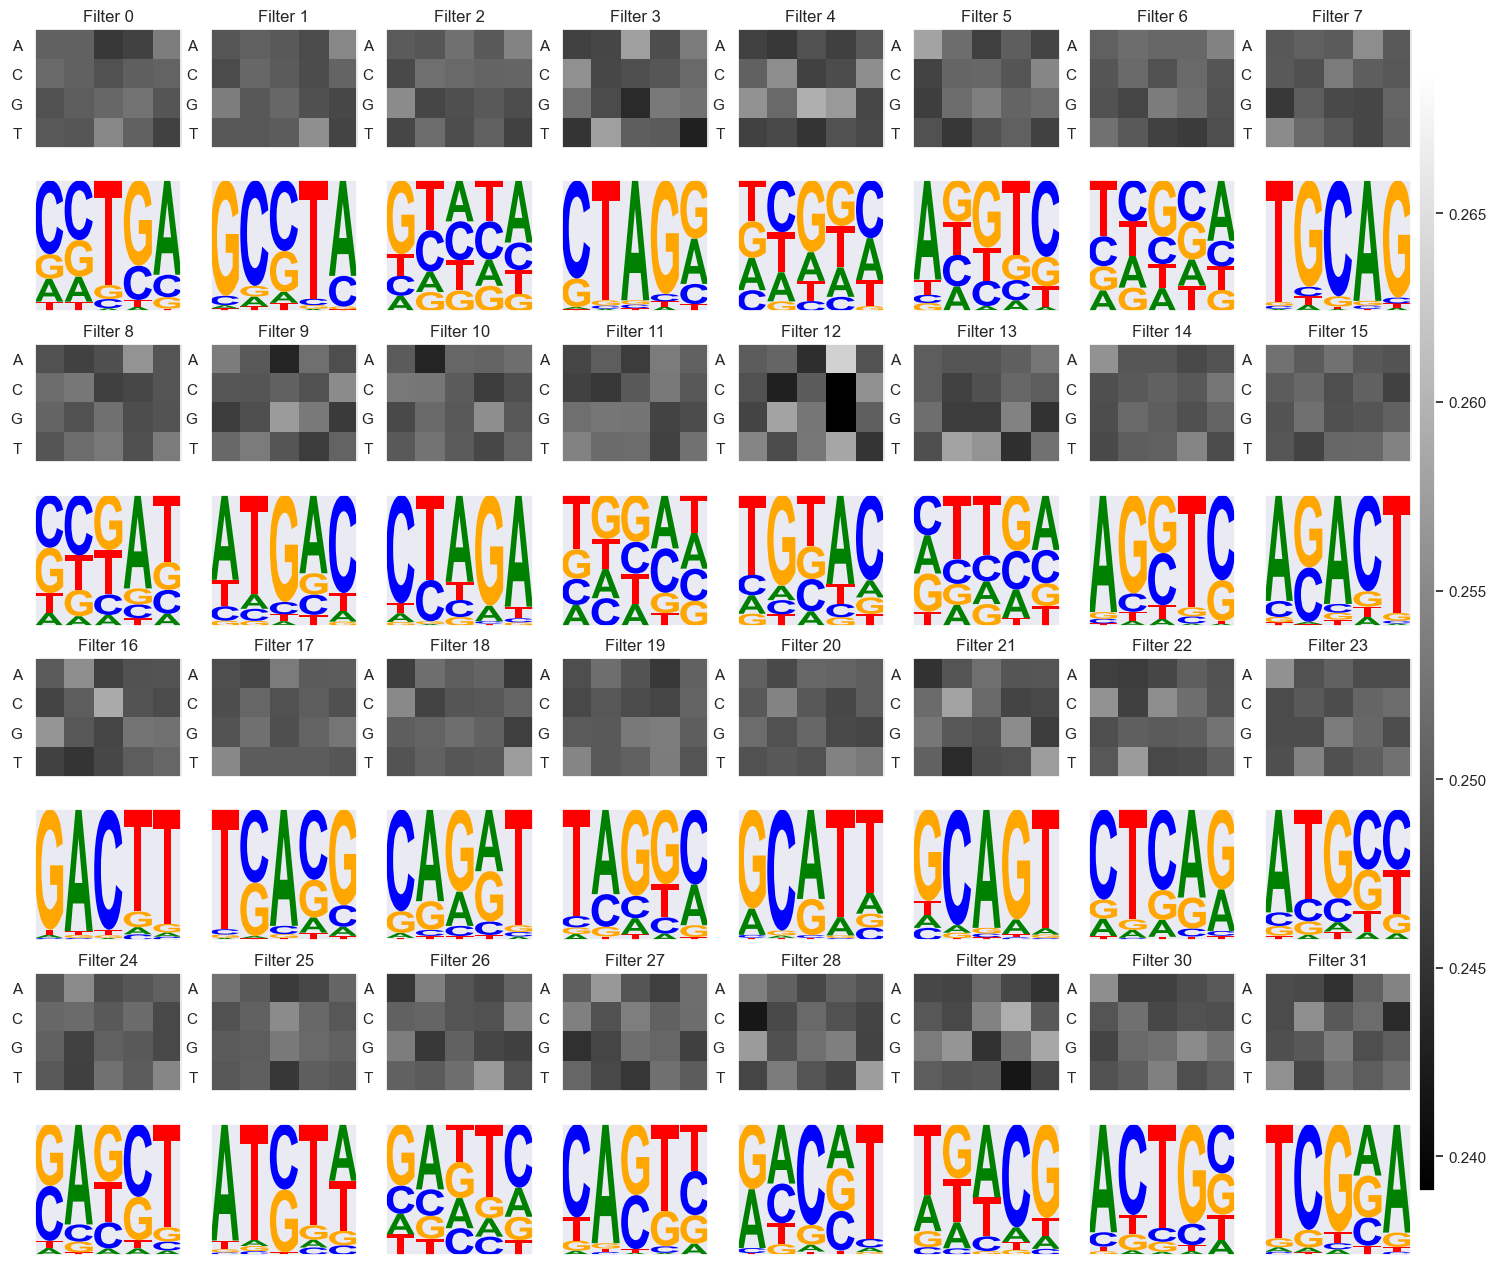

In [14]:
# Plot kernels and motifs

cnn_motifs.plot_kernels_and_motifs(
	weights          = data['weight'][0],
	activations      = activations,
	to_type          = display_motifs,
	nucleotide_order = nucleotide_order,
	filename         = os.path.join(OUT_DATA, 'activation-kernel-motif'),
	cols             = display_cols,
	rows             = display_rows,
	figsize          = display_size[1]
)